In [3]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn import discriminant_analysis
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
import time
import matplotlib.pyplot as plt
import warnings
import os
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from scipy.stats import spearmanr
import time
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
small_fig_size = [1, 1]

In [5]:
def saveFigure(file_name, fig, fig_size=small_fig_size, save_dir='Results'):
    # Save a figure and make it look nice
    #
    #
    
    # Make the save directory, if necessary
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    
    # Set the figure size
    fig.set_size_inches(fig_size[0], fig_size[1])
    
    # Build up the file name
    file_name = os.path.join(save_dir, file_name)
    
    # Get rid of grid and box
    for ax in fig.axes:
        
        ax.grid(b=False)
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(15)
        for item in ([ax.xaxis.label, ax.yaxis.label]):
            item.set_fontsize(12)
        
    
    # Save as a variety of file types
    fig.tight_layout()
    plt.show()
    plt.draw()
    
    fig.savefig(file_name+'.png',
                dpi=600)
    
    fig.savefig(file_name+'.pdf')

In [9]:
# Import data
filename = '../datasources/training_set_rel3.tsv'
df = pd.read_csv(filename, encoding='iso-8859-1', delimiter='\t')  ## error with utf-8 encoding
print 'Data shape: ', df.shape

# List of dataframes. Each dataframe contains data for each essay set.
dfs = []
dfs = [df[df['essay_set']==i+1] for i in range(8)]

# Turn into vector of features
vectorizers = [TfidfVectorizer() for i in range(8)]
corpuses = [dfs[i]['essay'].values for i in range(8)]
word_mats = [vectorizers[i].fit_transform(corpuses[i]) for i in range(8)]

# Save a copy of all the word matrices
word_mats = np.array(word_mats).copy()

responses_vars = [['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 1
                  ['rater1_domain1', 'rater2_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2', 'domain2_score'], ## essay set 2
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 3
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 4
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 5
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 6
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 7
                  ['rater1_domain1', 'rater2_domain1','domain1_score'] ## essay set 8
                ]
Y = [dfs[i][responses_vars[i]] for i in range(8)]

# Normalize the score to 0.0 - 1.0 scale.
for i in range(len(Y)):
    
    # Normalize
    max = Y[i]['domain1_score'].max()
    min = Y[i]['domain1_score'].min()
    
    a = 1.0/(max-min)
    b = float(-min)/(max-min)
    
    # Put it back
    Y[i]['domain1_score'] *= a
    Y[i]['domain1_score'] += b

Data shape:  (12976, 28)


In [10]:
# Fit a new multiple linear regression model on each essay set
def fitAndScoreModel(mdl, word_matrix, Y, graph=0, ax=0):
    # FITANDSCOREMODEL Fit and score a model for the current datafram
    #
    # INPUTS
    #             mdl: Model object
    #     word_matrix: Bag-of-words matrix. Dim 0 is essays and dim 1 is words
    #               Y: Scores corresponding to this essay set
    # OUTPUTS
    #             score: Score of testing data
        
    # Split into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(word_matrix, Y, test_size=0.1)
    
    # Initialize and fit the model
    mdl.fit(x_train, y_train)
    
    # Score the model and print
    pred_score = mdl.predict(x_test)
    
    # If prediction is out of bounds, fix it to 0/1.
    pred_score = np.array([0.0 if i < 0 else i for i in pred_score])
    pred_score = np.array([1.0 if i > 1 else i for i in pred_score])
    
    score = mdl.score(x_test, y_test)
    rho, p = spearmanr(y_test, pred_score)
    
    # Plot, if we want to
    if graph==1:
        handle = ax.plot([-0.1, 1.1], [-0.1, 1.1], color='#8996A0', zorder=0, label='Perfect\nmodel')
        ax.scatter(pred_score, y_test, marker='.', color='#992E24', zorder=1)

        # Cosmetic
        ax.set_title('%d %d; %d %d; %5.3f'%(pred_score.min(), pred_score.max(), y_test.min(), y_test.max(),
                                            score))
        ax.set_xlim([-0.01, 1.05])
        ax.set_ylim([-0.01, 1.05])
        ax.grid()
        
        
    return mdl.score(x_test, y_test), handle, rho

In [11]:
X = word_mats.copy()

 Essay-set 1:
  Score(R2): 0.229 



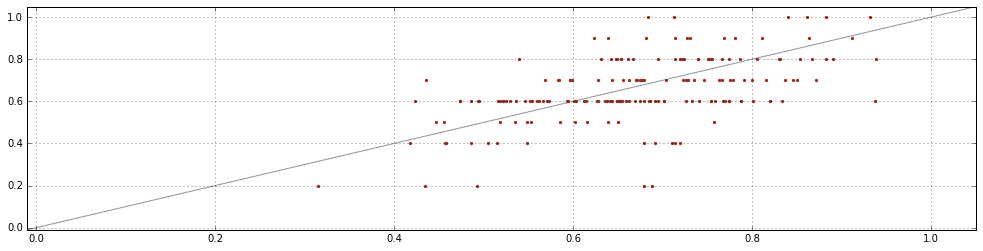

Essay-set 2:
  Score(R2): -0.11 



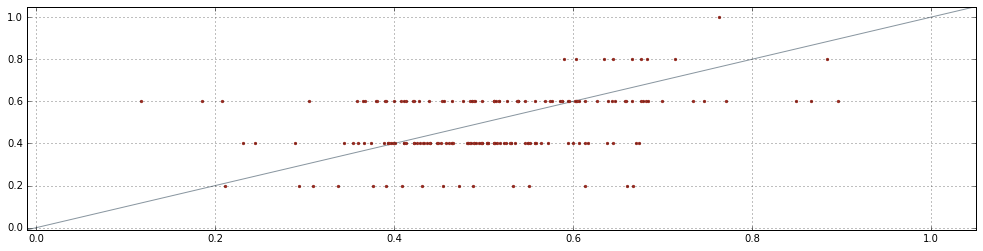

Essay-set 3:
  Score(R2): -0.09 



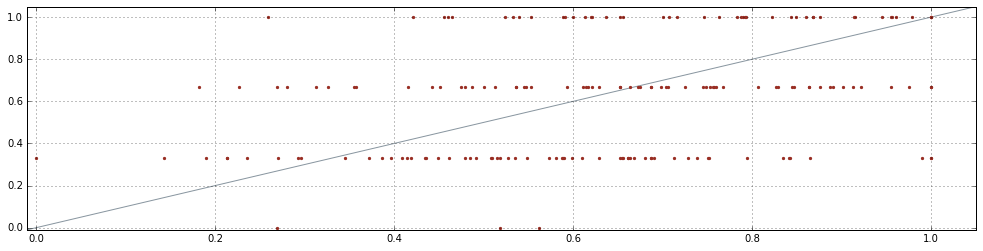

Essay-set 4:
  Score(R2): 0.052 



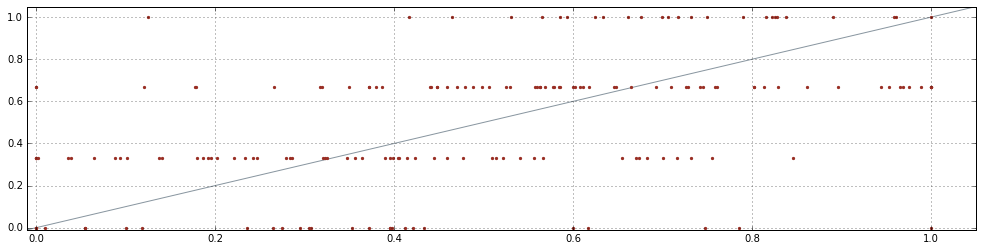

Essay-set 5:
  Score(R2): -0.269 



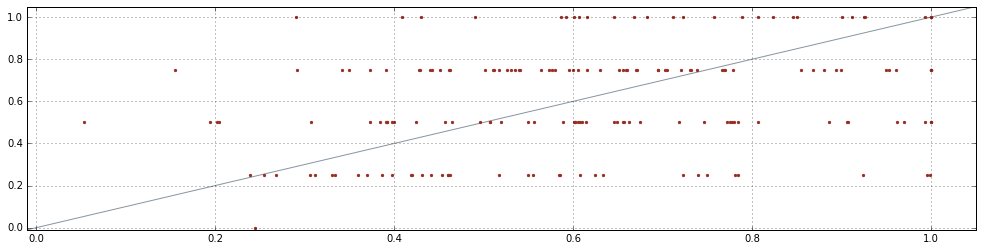

Essay-set 6:
  Score(R2): 0.047 



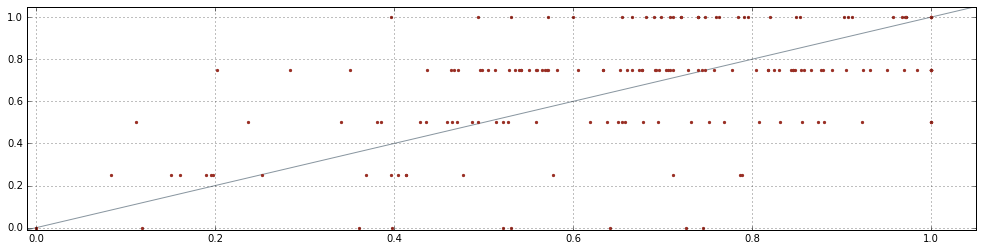

Essay-set 7:
  Score(R2): 0.384 



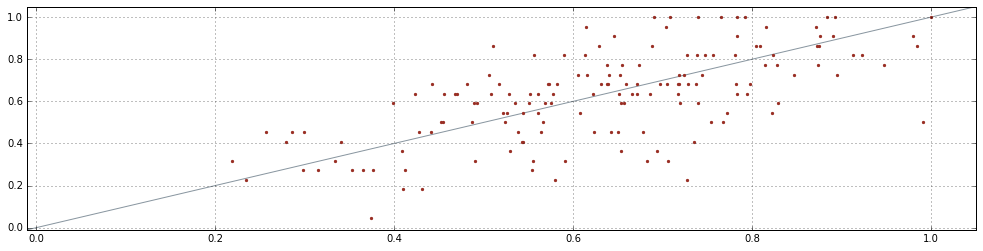

Essay-set 8:
  Score(R2): 0.266 



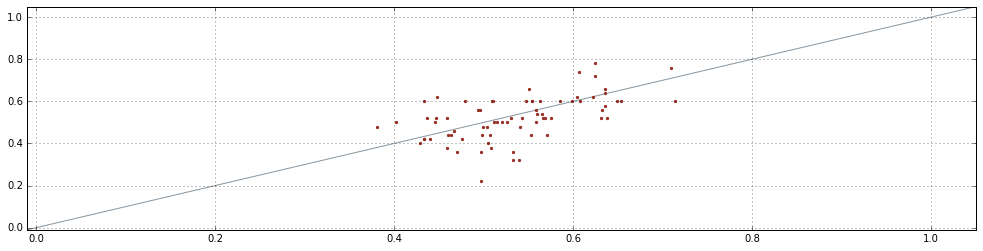

In [16]:
for i in range(8):
    fig = plt.figure(figsize=(17, 4))
    y = Y[i]['domain1_score'].values
    ax = fig.add_subplot(1, 1, 1)
    
    score = fitAndScoreModel(
                            mdl = linear_model.LinearRegression(),
                            word_matrix = X[i],
                            Y = Y[i]['domain1_score'].values,
                            graph=1, ax = ax
                            )[0]
    
    ax.set_title('')
    
    
    # Printing
    print 'Essay-set %d:'%(i+1)
    print '  Score(R2):', round(score, 3),'\n'
    plt.show()

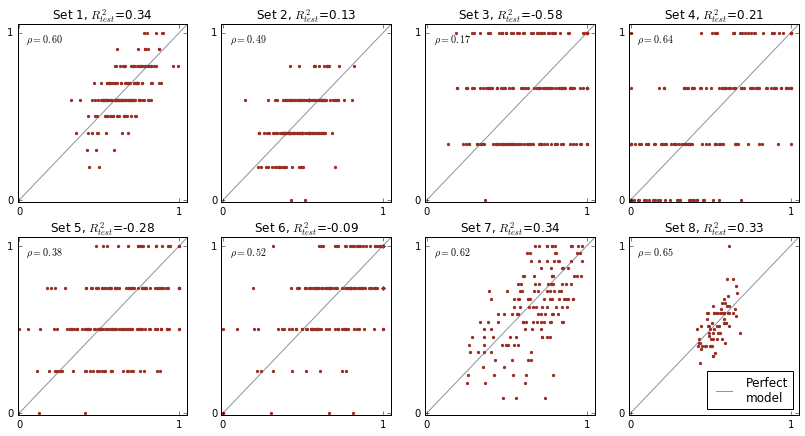

In [18]:
fig = plt.figure(figsize=(14, 7))

# Create the baseline model for every essay set
for i in range(8):
    
    ax = fig.add_subplot(2, 4, i+1)
    
    # Create and score the model
    y = Y[i]['domain1_score'].values
    
    score, line_handle, rho = fitAndScoreModel(
                            mdl = linear_model.LinearRegression(),
                            word_matrix = X[i],
                            Y = Y[i]['domain1_score'].values,
                            graph=1, ax = ax
                            )
    
    # Cosmet changes
    title = 'Set %d, $R^2_{test}$=%3.2f'%((i+1), score)
    
    ax.set_title(title)
    ax.set_xticks([0,  1])
    ax.set_yticks([0,  1])
    
    ax.grid()
    text = '$\\rho=%.2f$'%rho
    ax.text(0.05, 0.9, text, transform=ax.transAxes)
    
    # Add axis labels to the appropriate axes
    if i==7:
        ax.legend(handles=line_handle, loc='lower right')

plt.show()
saveFigure('baseline', fig_size=[9.5, 5.0], fig=fig)